In [17]:
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys
sys.path.insert(0, '../libraries/')
import gmm_clustering_lib as gmm_lib
import modeling_lib 
import utils_lib
import cluster_quantities_lib as cluster_lib
import optimization_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import json 

# Load data

We load and plot the iris dataset

In [18]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

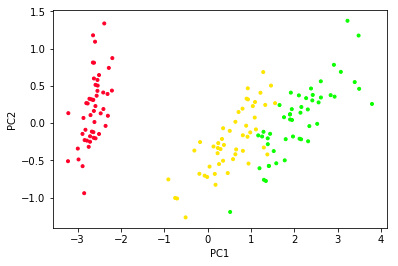

In [19]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [20]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = 13.5
print(prior_params_dict)

{'alpha': 13.5, 'prior_centroid_mean': array([0.]), 'prior_centroid_info': array([0.1]), 'prior_gamma_df': array([8.]), 'prior_gamma_inv_scale': array([[0.62, 0.  , 0.  , 0.  ],
       [0.  , 0.62, 0.  , 0.  ],
       [0.  , 0.  , 0.62, 0.  ],
       [0.  , 0.  , 0.  , 0.62]])}


### Variational parameters

In [21]:
# number of clusters in variational distribution 
k_approx = 30

In [22]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [23]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [24]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1773.5469149403084

# Optimize the KL objective

### Initialize with k-means

In [25]:
# run a kmeans init
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    optimization_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init)

gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights)

694.507666274968

### Set up KL objective 

In [26]:
# get loss as a function of vb parameters
get_vb_params_loss = paragami.Functor(original_fun=gmm_lib.get_kl, argnums=1)
get_vb_params_loss.cache_args(features, None, prior_params_dict,
                                gh_loc, gh_weights)

# Get loss as a function vb_free_params
get_loss = paragami.FlattenedFunction(original_fun=get_vb_params_loss,
                                        patterns=vb_params_paragami,
                                        free=True)


In [27]:
vb_opt = optimization_lib.optimize_full(get_loss, init_vb_free_params,
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
         Current function value: -303.863871
         Iterations: 162
         Function evaluations: 254
         Gradient evaluations: 244

 running preconditioned newton; iter =  0
computing preconditioner 
running newton steps
Optimization terminated successfully.
         Current function value: -303.863871
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter 0: x_diff = 4.415935899184533e-05, f_diff = 0.0, grad_l1 = 7.79603862807447e-11
done. 


In [28]:
vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)

In [29]:
# check results of kmeans init
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['centroids'], 
                                               np.linalg.inv(vb_params_dict['gamma']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


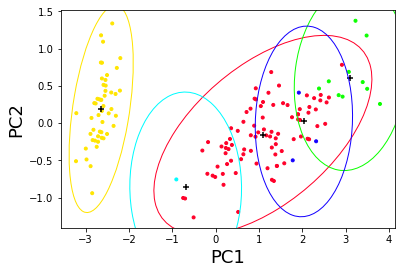

In [30]:
# Newton results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Parametric sensitivity

### Get the hyper parameter sensitivity object

In [18]:
get_prior_vb_loss = paragami.Functor(
    original_fun=gmm_lib.get_kl, argnums=[1, 2])

get_prior_vb_loss.cache_args(features, None, None, gh_loc, gh_weights)

In [19]:
vb_sens = \
    paragami.HyperparameterSensitivityLinearApproximation(
        objective_fun=           get_prior_vb_loss,
        opt_par_pattern=         vb_params_paragami,
        hyper_par_pattern=       prior_params_paragami,
        opt_par_folded_value=    vb_params_paragami.fold(vb_opt, free = True),
        hyper_par_folded_value=  prior_params_dict,
        opt_par_is_free=         True,
        hyper_par_is_free=       False,
        grad_tol=                1e-5)


### Set new prior

In [20]:
new_alpha = np.array([5.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['alpha'] = new_alpha


In [21]:
print('initial alpha, ', prior_params_dict['alpha'])
print('perturbed alpha, ', prior_params_pert_dict['alpha'])

initial alpha,  [3.]
perturbed alpha,  [5.]


### get linear response prediction

In [22]:
lr_vb_free_params = vb_sens.predict_opt_par_from_hyper_par(prior_params_pert_dict, fold_output = False)

print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))

l_inf diff:  0.9574721151055674


### re-optimize

In [23]:
vb_opt_pert = gmm_lib.optimize_full(features, vb_params_paragami, prior_params_pert_dict,
                    deepcopy(vb_opt), gh_loc, gh_weights,
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)

running bfgs ... 
         Current function value: -306.261991
         Iterations: 83
         Function evaluations: 207
         Gradient evaluations: 195

 running preconditioned newton; iter =  0
         Current function value: -306.261991
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 1
         Hessian evaluations: 1
Iter 0: x_diff = 1.0626829277660121e-12, f_diff = 9.663381206337363e-13, grad_l1 = 1.1587431260808026e-05
done. 


In [24]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')

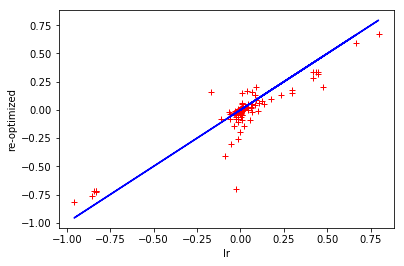

In [25]:
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

# Fit for a range of alpha 

In [26]:
alpha_list = np.arange(1, 9)

In [27]:
def refit_with_alpha(alpha, vb_opt): 
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    vb_opt_pert = gmm_lib.optimize_full(features, vb_params_paragami, prior_params_pert_dict,
                    deepcopy(vb_opt), gh_loc, gh_weights,
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)
    
    return vb_opt_pert

### Re-optimize

In [28]:
vb_pert_list = []
for alpha in alpha_list: 
    print('re-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, vb_opt))

re-optimzing with alpha =  1
running bfgs ... 
         Current function value: -329.430121
         Iterations: 89
         Function evaluations: 112
         Gradient evaluations: 111

 running preconditioned newton; iter =  0
Optimization terminated successfully.
         Current function value: -329.430121
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 1
Iter 0: x_diff = 4.2290123567560404e-06, f_diff = 7.958078640513122e-13, grad_l1 = 1.6745606474692642e-11
done. 
re-optimzing with alpha =  2
running bfgs ... 
         Current function value: -321.180868
         Iterations: 82
         Function evaluations: 174
         Gradient evaluations: 162

 running preconditioned newton; iter =  0
Optimization terminated successfully.
         Current function value: -321.180868
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 1
Iter 0: x_diff = 2.07

### get linear response

In [29]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(prior_params_pert_dict, fold_output = False))
    

### examine results 

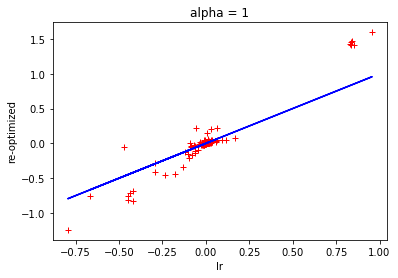

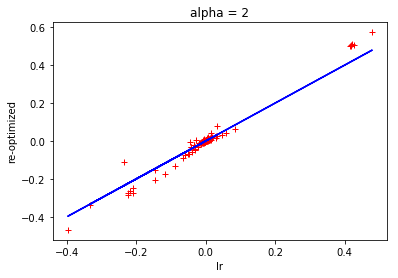

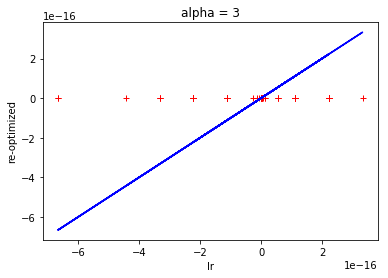

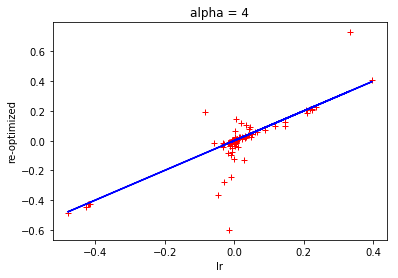

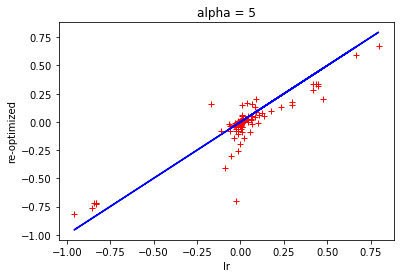

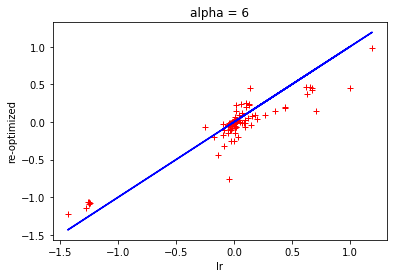

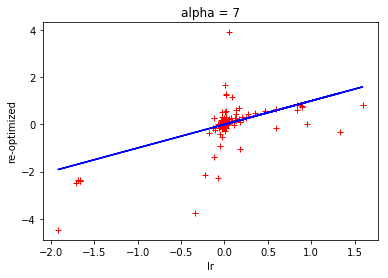

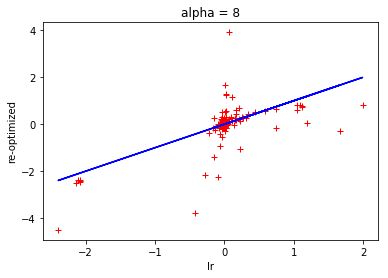

In [30]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))
    

In [31]:
# Posterior clusters
threshold = 0

lr_e_num_clusters_vec = np.zeros(len(alpha_list))
refit_e_num_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    lr_list[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_clusters_vec[i] = lr_e_num_clusters
    
    refit_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    vb_pert_list[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_clusters_vec[i] = refit_e_num_clusters
    


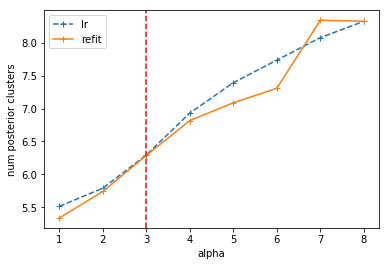

In [32]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')


In [33]:
# Posterior predictive clusters

threshold = 0

lr_e_num_pred_clusters_vec = np.zeros(len(alpha_list))
refit_e_num_pred_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    lr_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    lr_list[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_pred_clusters_vec[i] = lr_e_num_pred_clusters
    
    refit_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    vb_pert_list[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_pred_clusters_vec[i] = refit_e_num_pred_clusters
    


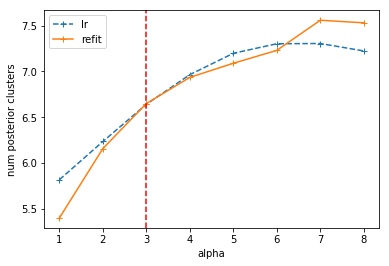

In [34]:
plt.plot(alpha_list, lr_e_num_pred_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_pred_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')
